In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
from PIL import Image 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import os

%matplotlib inline
plt.style.use("ggplot")


class CFG:
  batch_size = 128
  num_epochs = 5
  workers = 4
  seed = 2021
  image_size = 64
  download = True
  dataroot = "data"
  nc = 3 ## number chanels
  ngf = 64 #Size of feature maps in generator
  nz = 100 #latent random input vector
  ndf = 64 #Size of feature maps in discriminator
  lr = 0.0002
  device = 'cuda'
  sample_dir = "./images/"

if not os.path.exists(CFG.sample_dir):
  os.makedirs(CFG.sample_dir)
dataset = torchvision.datasets.CIFAR10(root=CFG.dataroot, download=CFG.download,
                               transform=transforms.Compose([
                                  transforms.Resize([CFG.image_size, CFG.image_size]),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))


Files already downloaded and verified


In [49]:
dataset[0][0].shape

torch.Size([3, 64, 64])

Label:  6


(array([ 1.,  3.,  4., 12., 41., 32.,  7.,  3.,  3.,  1.,  7., 11., 23.,
        26., 25.,  4.,  3.,  0.,  4.,  4., 12., 20., 20., 19., 15.]),
 array([-0.8745098 , -0.83654904, -0.7985882 , -0.76062745, -0.7226667 ,
        -0.68470585, -0.6467451 , -0.6087843 , -0.5708235 , -0.5328627 ,
        -0.49490196, -0.45694116, -0.41898036, -0.3810196 , -0.3430588 ,
        -0.305098  , -0.26713723, -0.22917643, -0.19121565, -0.15325487,
        -0.11529408, -0.07733329, -0.0393725 , -0.00141171,  0.03654907,
         0.07450986], dtype=float32),
 <a list of 25 Patch objects>)

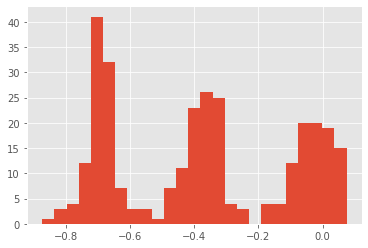

In [50]:
img, label = dataset[0]
print('Label: ', label)
plt.hist(img[:,5:15,5:15].flatten(), bins=25)

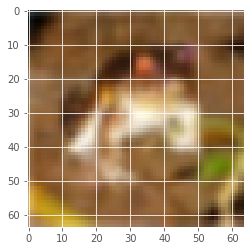

In [51]:
# unnormalization image from range (-1)-0 to range 0-1 to display it
def unnomalization(img):
    return img / 2 + 0.5

# show  image sample with matplotlib
plt.imshow(unnomalization(np.transpose(img, (1, 2, 0))))
plt.show()

In [52]:
# Create the dataloader
data_loader = DataLoader(dataset, batch_size=CFG.batch_size, shuffle=True)


## GAN 
состоит из двух глубоких сетей, генератора и дискриминатора. генератор создает изображения, прежде чем научиться его обучать. Поскольку дискриминатор представляет собой модель бинарной классификации, мы можем использовать функцию потери бинарной кросс-энтропии для количественной оценки того, насколько хорошо он может различать реальные и сгенерированные изображения.

In [200]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        """
          nc - количество слоев в возвращаемом (и исходном изображениях)
          nz - длина входного вектора латентного пространства
          ngf - размер feature map'ов в генераторе
        """
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        """
          nc - количество слоев во входных изображениях
          ndf - размер feature map'ов в дискриминаторе
        """
        #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [201]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [207]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(device)

D = Discriminator(CFG.nc, CFG.ndf).to(device)

print(G.apply(weights_init))
print(D.apply(weights_init))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, 

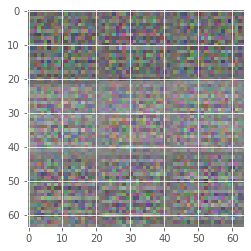

In [208]:

# show the output of model 
noise = torch.randn(2, CFG.nz, 1, 1, device=device)
y = G(noise)

# Вывод необученного генератора
plt.imshow(unnomalization(y.detach().cpu()[0].view(64, 64, 3)))
plt.show()

In [209]:
image = dataset[0][0].unsqueeze(0).to(device)
print(y.shape)
print(image.shape)
print(D(y))
print(D(image))

torch.Size([2, 3, 64, 64])
torch.Size([1, 3, 64, 64])
tensor([[0.1284],
        [0.6318]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.7603]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [210]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optimizer_g = torch.optim.Adam(G.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [211]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizer_g.zero_grad()
    optimizer_d.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)

    real_preds = D(images).to(device)

    d_loss = criterion(real_preds, real_labels)
    real_score = torch.mean(real_preds).item()

    # Loss for fake images
    z = torch.randn(images.size(0), CFG.nz, 1, 1).to(device)
    fake_images = G(z).to(device)

    fake_preds = D(fake_images).to(device)

    g_loss = criterion(fake_preds, fake_labels)
    fake_score = torch.mean(fake_preds).item()

    # Sum losses
    loss = d_loss + g_loss

    reset_grad()
    # Compute gradients
    loss.backward()

    # Adjust the parameters using backprop
    optimizer_d.step()
    
    return loss.item(), real_score, fake_score

In [212]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(CFG.batch_size, CFG.nz, 1,1).to(device)
    fake_images = G(z).to(device)
    labels = torch.ones(CFG.batch_size, 1).to(device)
    # calculate the generator loss
    preds = D(fake_images).to(device)
    loss = criterion(preds, labels)
    
    reset_grad()
    # Backprop and optimize
    loss.backward()
    optimizer_g.step()

    return loss.item(), fake_images

## Start the training proccess

In [213]:
def save_fake_images(index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz , 1 , 1).to(CFG.device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(unnomalization(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [214]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.to(device)
        
        # Train the discriminator  
        d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, _ = train_generator()
        # Inspect the losses
        if (i+1) % 10 == 0:
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss, 
                          real_score, fake_score))
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/5], Step [10/391], d_loss: 0.2725, g_loss: 7.5793, D(x): 0.88, D(G(z)): 0.10
Epoch [0/5], Step [20/391], d_loss: 0.1420, g_loss: 24.5625, D(x): 0.88, D(G(z)): 0.00
Epoch [0/5], Step [30/391], d_loss: 0.0060, g_loss: 19.7665, D(x): 0.99, D(G(z)): 0.00
Epoch [0/5], Step [40/391], d_loss: 0.1820, g_loss: 22.9417, D(x): 0.91, D(G(z)): 0.00
Epoch [0/5], Step [50/391], d_loss: 0.0246, g_loss: 23.3425, D(x): 0.98, D(G(z)): 0.00
Epoch [0/5], Step [60/391], d_loss: 1.0627, g_loss: 18.6791, D(x): 0.73, D(G(z)): 0.00
Epoch [0/5], Step [70/391], d_loss: 0.3079, g_loss: 23.0084, D(x): 0.86, D(G(z)): 0.00
Epoch [0/5], Step [80/391], d_loss: 0.1308, g_loss: 6.8929, D(x): 0.94, D(G(z)): 0.01
Epoch [0/5], Step [90/391], d_loss: 0.1583, g_loss: 7.6870, D(x): 0.94, D(G(z)): 0.00
Epoch [0/5], Step [100/391], d_loss: 0.0961, g_loss: 12.0245, D(x): 0.94, D(G(z)): 0.00
Epoch [0/5], Step [110/391], d_loss: 0.2233, g_loss: 5.0256, D(x): 0.90, D(G(z)): 0.06
Epoch [0/5], Step [120/391], d_loss: 0.7545, 

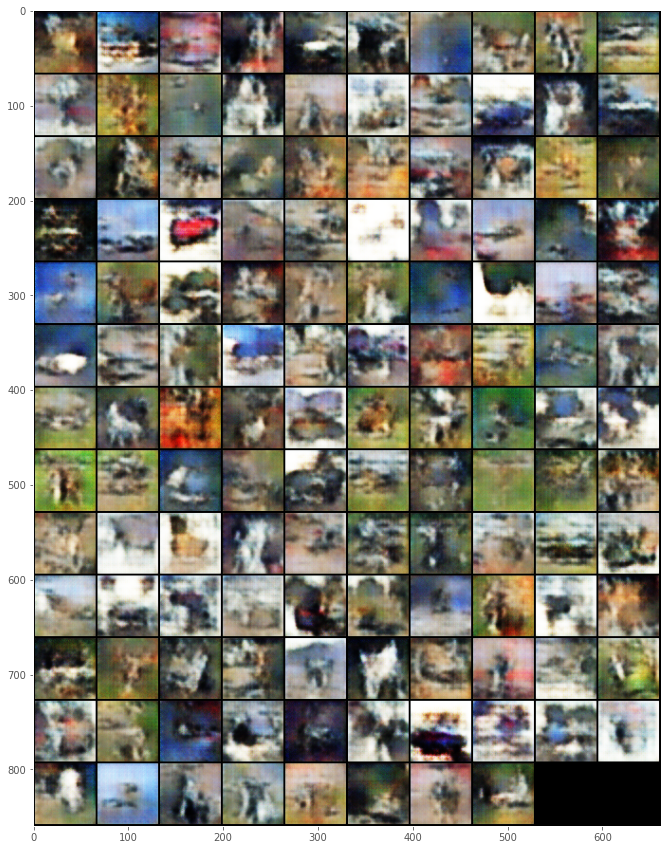

In [228]:
from PIL import Image                                                                                
img = Image.open(os.path.join(CFG.sample_dir, 'fake_images-0005.png'))
plt.figure(figsize=(15, 15))
plt.grid(False)
plt.imshow(img);

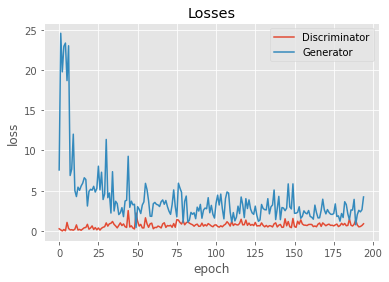

In [215]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

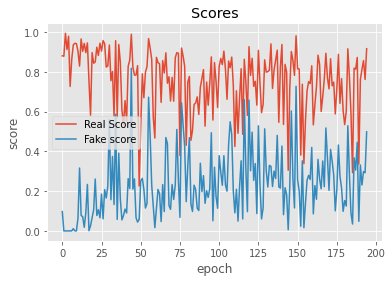

In [216]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [218]:
if not os.path.exists("./checkpoint/"):
    os.makedirs("./checkpoint/")
torch.save(
    G.state_dict(),
    "checkpoint/generator_model.pth")
torch.save(
    D.state_dict(),
    "checkpoint/discrimator_model.pth")